In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

df=pd.read_csv("./data/training_dataset.csv",low_memory=False)
df.match_date = df.match_date.apply(lambda x:datetime.strptime(x, '%Y-%m-%d'))

In [2]:
df

,player1_name,player1_atprank,player2_name,player2_atprank,match_date,match_location,match_tournament,match_surface,match_odd_player1,match_odd_player2,winner_player1
0,Harrison R.,481,Mager G.,67,2021-01-07,Delray Beach,Delray Beach Open,Hard,1.72,2.00,0
1,Korda S.,26,Kwon S.W.,68,2021-01-07,Delray Beach,Delray Beach Open,Hard,1.72,2.00,1
2,Paul T.,14,Nam J.S.,590,2021-01-07,Delray Beach,Delray Beach Open,Hard,1.12,6.00,1
3,Travaglia S.,1024,Kecmanovic M.,40,2021-01-07,Antalya,Antalya Open,Hard,2.62,1.44,1
4,Monteiro T.,121,Bellucci T.,915,2021-01-07,Delray Beach,Delray Beach Open,Hard,1.36,3.00,1
...,...,...,...,...,...,...,...,...,...,...,...
7057,Tiafoe F.,10,Evans D.,30,2023-08-05,Washington,Citi Open,Hard,1.29,3.75,0
7058,Fritz T.,9,Griekspoor T.,37,2023-08-06,Washington,Citi Open,Hard,1.30,3.50,0
7059,Tsitsipas S.,5,De Minaur A.,19,2023-08-06,Los Cabos,Los Cabos Open,Hard,1.36,3.20,1
7060,Dimitrov G.,20,Evans D.,30,2023-08-06,Washington,Citi Open,Hard,1.36,3.20,0


In [3]:
df = df.dropna()

In [15]:
from sklearn.model_selection import train_test_split

X = df[["player1_atprank", "player2_atprank","match_date", "match_odd_player1", "match_odd_player2"]]
y = df.winner_player1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)# shuffle=False)

In [16]:
from sklearn import preprocessing

X_train_filtered = X_train.drop("match_date",axis=1)
X_test_filtered = X_test.drop("match_date",axis=1)

#normalisation is useless for gradientboostingclassifier
#scaler = preprocessing.StandardScaler().fit(X_train_filtered)
#X_train_filtered = scaler.transform(X_train_filtered)
#X_test_filtered = scaler.transform(X_test_filtered)

X_train_filtered

,player1_atprank,player2_atprank,match_odd_player1,match_odd_player2
3531,15,66,2.00,1.80
4524,107,44,2.62,1.50
2703,30,12,2.00,1.80
6762,8,79,1.14,5.50
31,26,14,2.37,1.53
...,...,...,...,...
5106,4,12,3.20,1.36
4515,44,37,1.53,2.50
5725,108,95,2.63,1.50
5314,86,44,1.57,2.38


In [6]:
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score


model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)
model = model.fit(X_train_filtered, y_train)

#cross_val_score(dtree, X_test, y_test, cv=10)

y_predict = model.predict(X_test_filtered)

accuracy_score(y_predict, y_test)

0.6728307254623044

In [7]:
# ROI return of investment on all games

print("We bet 1€ on all test matches")
df_roi = X_test.copy()
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

money_invested=df_roi.shape[0]
print("money spent:", money_invested,"€")

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won,2) - money_invested,"€")

We bet 1€ on all test matches
money spent: 1406 €
money won: 1344.11 €
TOTAL: -61.8900000000001 €


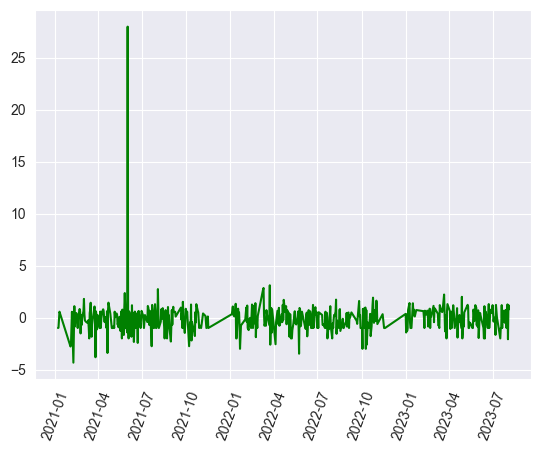

In [67]:
# on all games 
import matplotlib.pyplot as plt

df_roi = df_roi.sort_values(by='match_date')
dates = df_roi.match_date.unique()
data = []

for date in dates :
    money_won = 0.0
    #test = df_roi.at[df_roi.index[0],"match_date"]
    df_roi_filtered = df_roi.loc[df_roi["match_date"]==date]
    #print(df_roi_filtered)
    money_won-=df_roi_filtered.shape[0]

    for index, row in (df_roi_filtered.loc[df_roi_filtered["y_predict"] == df_roi_filtered["y_test"]]).iterrows():
        if row.y_predict == 0 :
            money_won += row.match_odd_player2
        else:
            money_won += row.match_odd_player1

    data.append(money_won)

dates = dates.astype('datetime64[ns]')

plt.plot_date(pd.to_datetime(dates.date, format='%Y-%m-%d'), data, 'g')
plt.xticks(rotation=70)
plt.show()


d = {'date': dates.date, 
     'money_won': data}
roi = pd.DataFrame(data=d)

In [10]:
#only games where predict proba is > 0.8

y_predict_proba = model.predict_proba(X_test_filtered)


print("We bet 1€ on all test matches where proba score is > 0.8")
df_roi = X_test.copy()
df_roi["y_predict_proba"] = y_predict_proba[:,0]   #all rows, first column = prediction score for winner 1 
df_roi["y_predict"] = y_predict
df_roi["y_test"]=y_test

df_roi= df_roi.loc[(df_roi["y_predict_proba"]>0.9) | (df_roi["y_predict_proba"]<0.1)]

money_invested=df_roi.shape[0]
print("money spent:", money_invested,"€")

money_won = 0.0
for index, row in (df_roi[y_predict == y_test]).iterrows():
    if row.y_predict == 0 :
        money_won += row.match_odd_player2
    else:
        money_won += row.match_odd_player1

print("money won:",round(money_won,2),"€")
print("TOTAL:", round(money_won,2) - money_invested,"€")
                

We bet 1€ on all test matches where proba score is > 0.8
money spent: 100 €
money won: 100.95 €
TOTAL: 0.9500000000000028 €


C:\Users\chbou\AppData\Local\Temp\ipykernel_10408\2133200740.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for index, row in (df_roi[y_predict == y_test]).iterrows():


In [14]:
df_roi

,player1_atprank,player2_atprank,match_date,match_odd_player1,match_odd_player2,y_predict_proba,y_predict,y_test
1453,652,2,2021-06-30,19.00,1.02,0.977252,0,0
1677,166,4,2021-07-22,8.00,1.08,0.927625,0,0
1017,19,164,2021-05-12,1.07,9.00,0.063723,1,1
5181,717,48,2023-01-09,10.00,1.06,0.958986,0,0
4577,76,5,2022-08-30,13.00,1.04,0.953336,0,1
...,...,...,...,...,...,...,...,...
5358,14,2,2023-01-27,11.00,1.05,0.950354,0,0
6484,77,2,2023-06-04,15.00,1.03,0.964051,0,0
3780,19,70,2022-05-27,1.08,8.00,0.083542,1,1
3000,2,18,2022-02-21,1.06,10.00,0.096299,1,1
